# IMDB GRU

## #01. 패키지 준비하기

In [1]:
import helper
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## #02. 데이터셋 준비

In [2]:
# 가장 빈번하게 사용되는 단어의 개수.
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

17464789/17464789 [==============================] - 2s 0us/step
훈련 데이터 (25000,) 레이블 (25000,)
검증 데이터 (25000,) 레이블 (25000,)


## #03. 데이터 전처리

### 1. 데이터를 동일한 길이로 맞추기 (padding)

In [3]:
# 최대 문장 길이
max_len = 500

print('Before pad_sequences: ', len(x_train[0]), len(x_train[1]))

pad_x_train = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding = 'pre')

#  원래 단어의 앞에 ‘지정해준 단어의 길이 – 원래 단어의 길이’(500 –218)만큼 0이 추가된 것을 볼 수 있다.
print('After pad_sequences: ', len(pad_x_train[0]), len(pad_x_train[1]))

print(pad_x_train[0])

Before pad_sequences:  218 189
After pad_sequences:  500 500
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

## #04. 데이터셋 분할하기

이미 데이터셋이 훈련데이터와 검증데이터로 분리되어 있기 때문에 별도의 분할 작업을 수행할 필요는 없다.

## #05. 모델 개발

### 모델 정의 (RNN)

return_sequences 파라미터가 True로 지정되면 모든 학습 시점의 은닉 상태를 출력해 준다. False인 경우는 마지막 시점의 은닉 상태만 출력한다. (기본값=False)

dropout은 지정된 비율만큼 학습을 건너뛰게 하는 파라미터. 이 파라미터를 사용하게 되면 과거 학습정보를 잃어버릴 확률이 높아지고 그에 따라 모델 성능이 나빠질 가능성이 있다.

recurrent_dropout(순환드롭아웃)은 과거 학습정보를 잃어버리는 문제를 해결하기 위해 적용하는 옵션.

In [4]:
model = Sequential()

model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_len))
# 딱 한 층만 쌓아야 한다.(Dog꿀~!!)
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

# 결국은 긍정, 부정을 분류 하는 문제이므로 이진분류에 해당한다.
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 326369 (1.24 MB)
Trainable params: 326369 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [5]:
result = model.fit(pad_x_train, y_train, epochs=500, validation_data=(pad_x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
782/782 [==============================] - 110s 132ms/step - loss: 0.4456 - acc: 0.7825 - val_loss: 0.3347 - val_acc: 0.8587 - lr: 0.0010
Epoch 2/500
782/782 [==============================] - 43s 55ms/step - loss: 0.2480 - acc: 0.9040 - val_loss: 0.3247 - val_acc: 0.8616 - lr: 0.0010
Epoch 3/500
782/782 [==============================] - 36s 46ms/step - loss: 0.1887 - acc: 0.9297 - val_loss: 0.3270 - val_acc: 0.8604 - lr: 0.0010
Epoch 4/500
782/782 [==============================] - 25s 32ms/step - loss: 0.1457 - acc: 0.9484 - val_loss: 0.3406 - val_acc: 0.8639 - lr: 0.0010
Epoch 5/500
782/782 [==============================] - ETA: 0s - loss: 0.1137 - acc: 0.9614
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 [==============================] - 22s 29ms/step - loss: 0.1137 - acc: 0.9614 - val_loss: 0.3841 - val_acc: 0.8704 - lr: 0.0010
Epoch 6/500
782/782 [==============================] - 27s 35ms/step - loss: 0.0658 - acc: 0.9800 - va

## #06. 학습결과 평가

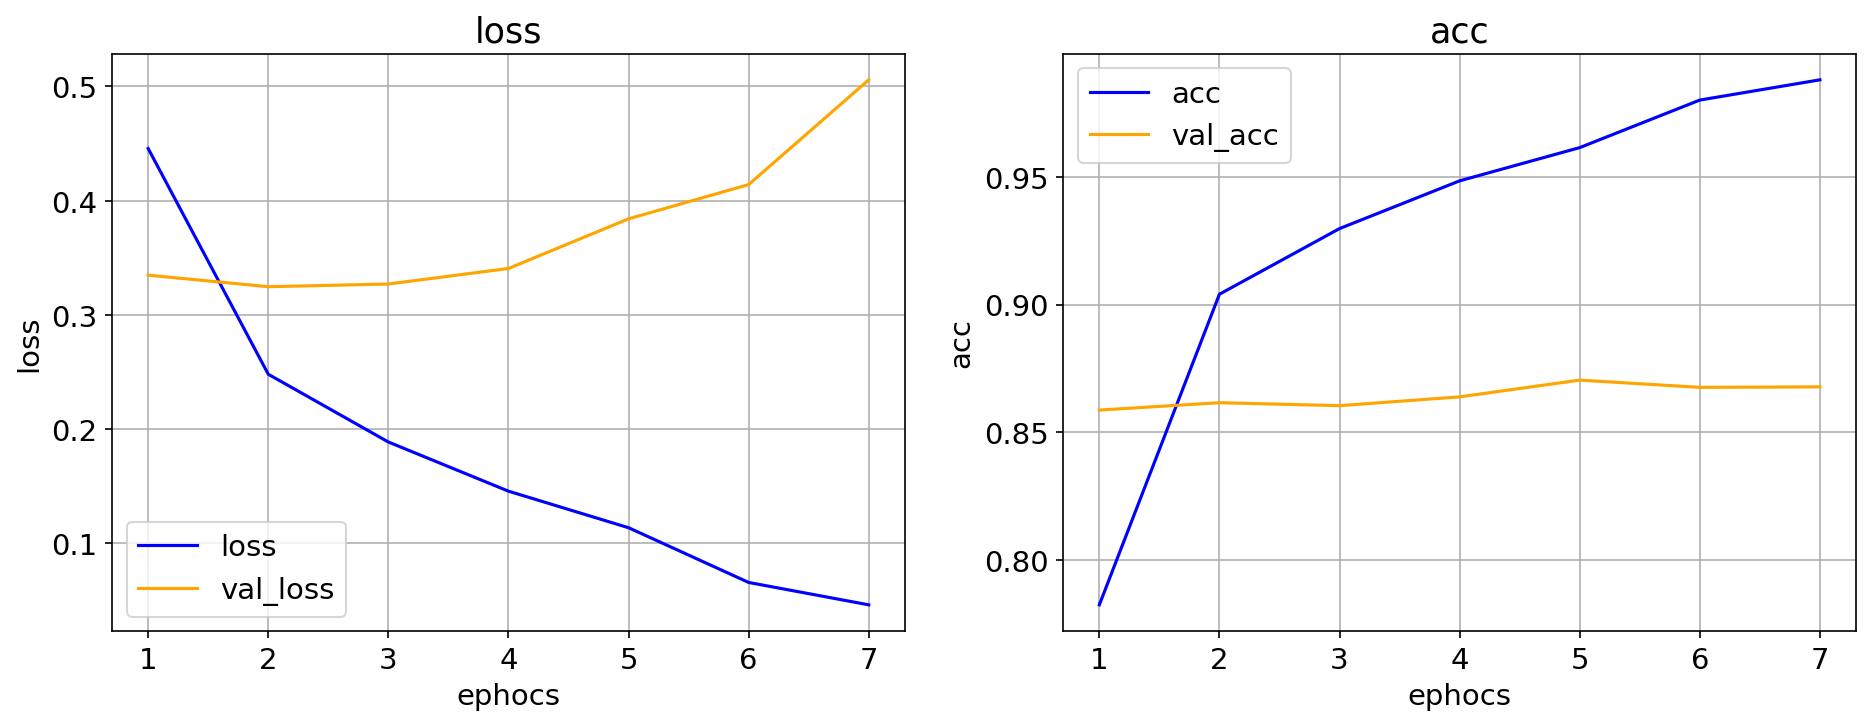

782/782 [==============================] - 6s 8ms/step - loss: 0.0298 - acc: 0.9930
최종 훈련 손실률: 0.029826, 최종 훈련 정확도: 0.992960
782/782 [==============================] - 6s 8ms/step - loss: 0.5057 - acc: 0.8678
최종 검증 손실률: 0.505750, 최종 검증 정확도: 0.867800


In [6]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(pad_x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(pad_x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #06. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [7]:
result = model.predict(pad_x_train)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

782/782 [==============================] - 6s 8ms/step
25000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[9.9976617e-01],
       [1.1389301e-03],
       [2.3355901e-04],
       ...,
       [7.7753229e-04],
       [9.9921966e-01],
       [4.6745192e-02]], dtype=float32)

### 예측 결과를 1차원 배열로 변환

In [8]:
f_results = result.flatten()
f_results

array([9.9976617e-01, 1.1389301e-03, 2.3355901e-04, ..., 7.7753229e-04,
       9.9921966e-01, 4.6745192e-02], dtype=float32)

### 결과 데이터 프레임 구성

In [9]:
kdf = DataFrame({
    'train': y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')
kdf

,train,pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
24995,1,1
24996,0,0
24997,0,0
24998,1,1


### 실제 결과값과 머신러닝에 의한 예측값 비교

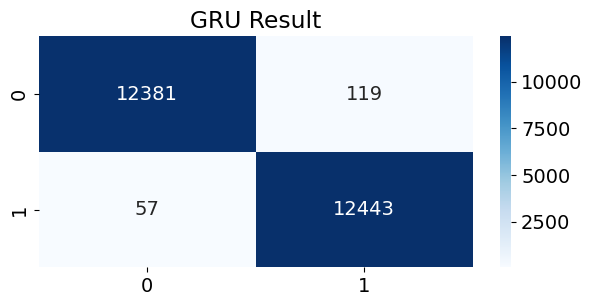

In [15]:
cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.title('GRU Result')
plt.show()
plt.close()